In [38]:
%matplotlib inline

In [39]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
import os
import sys
import re

In [41]:
import numpy as np
from scipy.io import wavfile
import tensorflow as tf
from tensorflow.python.ops import io_ops

## Load custom libraries

In [42]:
import config as cfg
from dataload import load_data
from preprocessing import signalProcessBatch

## Tensorflow setup

In [7]:
# Tensorflow setup
sess = None
tf.logging.set_verbosity(tf.logging.INFO)

def reset_vars():
    """Initializes all tf variables"""
    sess.run(tf.global_variables_initializer())

def reset_tf():
    """Closes the current tf session and opens new session"""
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

## Load some audio training files to test

In [8]:
df = load_data(cfg.DATA_DIR)

In [9]:
df_train = df[df.setlabel == 'train']

In [10]:
df_train.head(10)

,filepath,label,uid,uversion,setlabel,reqlabel,reqlabelflag
0,right/988e2f9a_nohash_0.wav,right,988e2f9a,0,train,right,True
1,right/1eddce1d_nohash_3.wav,right,1eddce1d,3,train,right,True
2,right/93ec8b84_nohash_0.wav,right,93ec8b84,0,train,right,True
3,right/6272b231_nohash_1.wav,right,6272b231,1,train,right,True
5,right/2f813234_nohash_1.wav,right,2f813234,1,train,right,True
6,right/b87bdb22_nohash_1.wav,right,b87bdb22,1,train,right,True
9,right/51055bda_nohash_4.wav,right,51055bda,4,train,right,True
10,right/fac74f6a_nohash_1.wav,right,fac74f6a,1,train,right,True
11,right/a8cb6dda_nohash_0.wav,right,a8cb6dda,0,train,right,True
12,right/e4a2cf79_nohash_0.wav,right,e4a2cf79,0,train,right,True


In [11]:
# Weights to allow for larger numbers of unknowns
weights = np.where(df_train.reqlabelflag, 1.0, 1850. / 32550.)

In [12]:
1850. / 32550.

0.05683563748079877

In [13]:
# Select a random sample of files
batch_size = 100
df_train_batch = df_train.sample(n=batch_size, weights=weights)

In [14]:
X_list = df_train_batch.filepath
y_label = df_train_batch.reqlabel

In [15]:
X = np.zeros([batch_size, cfg.SAMRATE])
for i, f in enumerate(X_list):
    sr, wave = wavfile.read(os.path.join(cfg.DATA_DIR, 'train', 'audio', f))
    wave.resize(16000)
    X[i] += wave

In [16]:
X.shape

(100, 16000)

In [17]:
reset_tf()

In [18]:
# Note that noise_factor=0 is faster than setting add_noise=False
#%timeit -r 1 -n 1
mfccs, mel_spectrograms, zcr, rmse = sess.run(signalProcessBatch(X, add_noise=True, noise_factor=0.1,
                                                                 window=512, maxamps=cfg.MAXAMPS, sr=16000,
                                                                 num_mel_bins=64, num_mfccs=13))

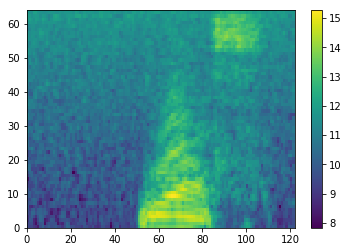

In [19]:
# No Noise
plt.pcolormesh(mel_spectrograms[50].T)
plt.colorbar();

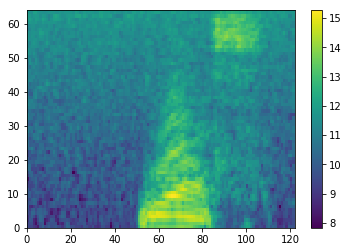

In [20]:
# With added noise from NOISE_MATRIX, noise_factor=0.1
plt.pcolormesh(mel_spectrograms[50].T)
plt.colorbar();

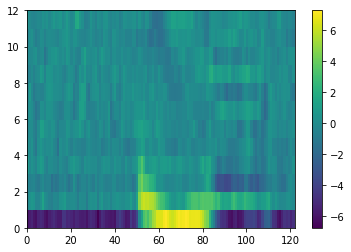

In [21]:
# With added noise from NOISE_MATRIX, noise_factor=0.1
plt.pcolormesh(mfccs[50].T[1:])
plt.colorbar();

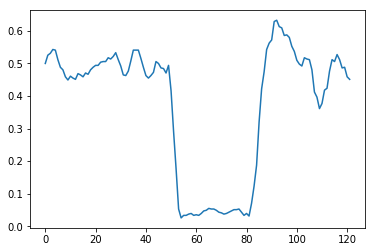

In [22]:
plt.plot(zcr[50]);

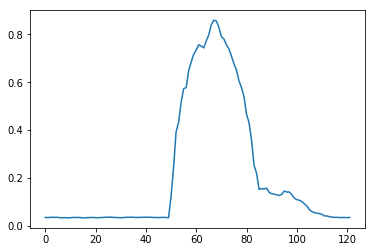

In [23]:
plt.plot(rmse[50]);

## Wrap file batch load into function

In [24]:
def load_batch(datapath, batch_size=100, silence_size=5, label='train', random=True, seed=None,
               w=0.0568, samples=16000):
    """Loads a batch of audio data files and returns the tensor of waves.
       Also returns the truth values.
       If random is True then it selects a random batch else it selects a
       continuous batch starting at seed."""
    df = load_data(datapath)
    df_req = df[df.setlabel == label]
    
    # Weights to allow for larger numbers of unknowns
    weights = np.where(df_req.reqlabelflag, 1.0, w)
    
    # Select the required rows of the dataframe (randomly or in order)
    non_silence_size = batch_size - silence_size
    if random:
        np.random.seed(seed)
        df_req_batch = df_req.sample(n=non_silence_size, weights=weights)
    else:
        if not seed:
            seed = 0
        df_req_batch = df_req.iloc[seed:seed + non_silence_size]
    
    # Select files and y_true
    X_list = df_req_batch.filepath
    y_true = df_req_batch.reqlabel.map(cfg.LABEL2NUM).values
    
    # Add silence labels to end
    y_true = np.hstack([y_true, silence_size * [cfg.LABEL2NUM['silence']]])
    
    # 1-hot encode labels
    y_true_onehot = np.eye(len(cfg.LABEL2NUM))[y_true]
    
    # Empty array of size (batch_size x samples)
    X = np.zeros([batch_size, samples])
    
    # Load each wave file and add it to the array X
    for i, f in enumerate(X_list):
        sr, wave = wavfile.read(os.path.join(datapath, 'train', 'audio', f))
        # Reshape all files to be same length (i.e. samples)
        wave.resize(samples)
        X[i] += wave

    return X, y_true_onehot

In [25]:
w = 1850. / 32550.

In [26]:
X, y_true = load_batch(cfg.DATA_DIR, batch_size=25, silence_size=2, label='train', random=True, seed=42,
                       w=w, samples=cfg.SAMRATE)

In [27]:
X

array([[ -2.10000000e+01,  -2.70000000e+01,  -2.40000000e+01, ...,
         -7.40000000e+01,  -8.10000000e+01,  -5.00000000e+01],
       [  0.00000000e+00,  -1.00000000e+00,  -1.00000000e+00, ...,
         -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00],
       [  4.10000000e+01,   5.80000000e+01,   7.20000000e+01, ...,
          1.07000000e+02,  -8.10000000e+01,   8.00000000e+00],
       ..., 
       [ -2.02700000e+03,  -2.15500000e+03,  -2.15100000e+03, ...,
         -1.42000000e+03,  -1.90800000e+03,  -2.34400000e+03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [28]:
y_true

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  

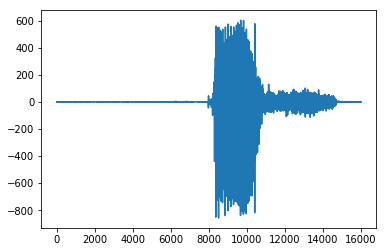

In [29]:
plt.plot(X[1]);

In [30]:
import IPython.display as ipd

In [31]:
ipd.Audio(X[1], rate=cfg.SAMRATE)

In [63]:
cfg.NUM2LABEL

{0: 'unknown',
 1: 'yes',
 2: 'no',
 3: 'up',
 4: 'down',
 5: 'left',
 6: 'right',
 7: 'on',
 8: 'off',
 9: 'stop',
 10: 'go',
 11: 'silence'}